In [1]:
import pickle
import gzip
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

In [4]:
processed_data = load_zipped_pickle("/content/drive/MyDrive/data/train_processed.pkl")

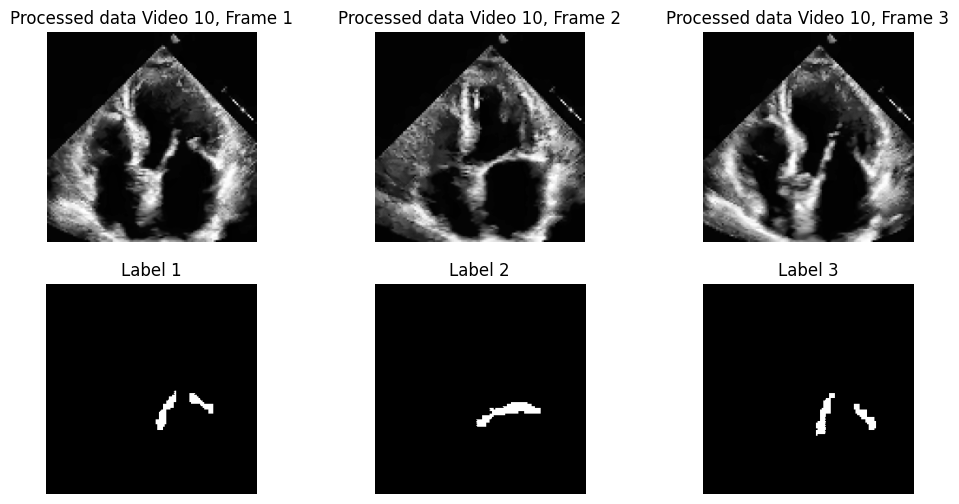

In [5]:
def plot_processed_frames(data, video_number=0, title=None):
    # Get the frames and labels of the selected video
    video_frames = data[video_number]['video']
    video_labels = data[video_number]['label']
    num_frames = video_frames.shape[-1]

    # Create subplots
    fig, axs = plt.subplots(2, num_frames, figsize=(12, 6))

    # Plot frames of the selected video
    for i in range(num_frames):
        frame = video_frames[..., i]  # Get the i-th frame
        axs[0, i].imshow(frame, cmap='gray')
        axs[0, i].axis('off')
        if title:
            axs[0, i].set_title(f"{title} Video {video_number}, Frame {i+1}")

    # Plot labels of the selected video
    for i in range(num_frames):
        label = video_labels[..., i]  # Get the i-th label
        axs[1, i].imshow(label, cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title(f"Label {i+1}")

    plt.show()



# Plot frames for amateur video
plot_processed_frames(processed_data, 10, 'Processed data')


In [6]:
import numpy as np

def calculate_class_frequency(labels):
    """
    Calculate the frequency of each class in the given labels.
    Assuming binary classes with 0 representing the background and 1 the foreground.
    """
    background_count = 0
    foreground_count = 0

    # Iterate through each label (mask)
    for label in labels:
        # Flatten the label mask
        label_flat = label.flatten()

        # Count number of pixels for each class
        background_count += np.count_nonzero(label_flat == 0)
        foreground_count += np.count_nonzero(label_flat == 1)

    return background_count, foreground_count


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

videos = [entry['video'] for entry in processed_data]
labels = [entry['label'] for entry in processed_data]

height = 256
width = 256

X_frames = []
y_labels = []

for video, label in zip(videos, labels):
    num_frames = video.shape[-1]
    for i in range(num_frames):
        frame = video[:, :, i]
        label_frame = label[:, :, i]

        X_frames.append(frame)
        y_labels.append(label_frame)

X = np.array(X_frames).reshape(-1, height, width, 1)  # Adding channel dimension
y = np.array(y_labels).reshape(-1, height, width, 1)  # Adding channel dimension

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Assuming y_train is your array of training labels (masks)
background_count, foreground_count = calculate_class_frequency(y_train)

print(f"Background Pixels: {background_count}")
print(f"Foreground Pixels: {foreground_count}")



X shape: (195, 256, 256, 1)
y shape: (195, 256, 256, 1)
Background Pixels: 10138319
Foreground Pixels: 85297


In [8]:
total_pixels = background_count + foreground_count

# Calculate weights
weight_for_background = (1 / background_count) * (total_pixels) / 2.0
weight_for_foreground = (1 / foreground_count) * (total_pixels) / 2.0

print("Weight for Background:", weight_for_background)
print("Weight for Foreground:", weight_for_foreground)


Weight for Background: 0.5042066638463437
Weight for Foreground: 59.929516864602505


In [17]:
total_weight = weight_for_background + weight_for_foreground
weight_for_background = weight_for_background / total_weight
weight_for_foreground = weight_for_foreground / total_weight


## Model simple Unet

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def conv_block(input_tensor, num_filters):
    # First layer
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    if use_BN:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Second layer
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    if use_BN:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def unet_model(input_shape, num_filters=64, use_BN=True):
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, num_filters)
    x2, p2 = encoder_block(p1, num_filters*2)
    x3, p3 = encoder_block(p2, num_filters*4)
    x4, p4 = encoder_block(p3, num_filters*8)

    # Bridge
    bridge = conv_block(p4, num_filters*16)

    # Decoder
    d1 = decoder_block(bridge, x4, num_filters*8)
    d2 = decoder_block(d1, x3, num_filters*4)
    d3 = decoder_block(d2, x2, num_filters*2)
    d4 = decoder_block(d3, x1, num_filters)

    # Output
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model



In [10]:
input_shape = (256, 256, 1)  # Adjust to your dataset
use_BN = True  # Use Batch Normalization

unet = unet_model(input_shape, use_BN=use_BN)


learning_rate = 1e-4

optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
'''
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
'''

#unet.summary()

"\ncallbacks = [EarlyStopping(monitor='val_loss', patience=10),\n                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]\n"

In [11]:
import numpy as np
from tensorflow.keras import backend as K

def jaccard_loss(y_true, y_pred):
    """Calculates Jaccard index (IoU)"""
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return 1- ((intersection + K.epsilon()) / (union + K.epsilon()))



In [12]:
import numpy as np
from tensorflow.keras import backend as K

def jaccard_index(y_true, y_pred):
    """Calculates Jaccard index (IoU)"""
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return (intersection + K.epsilon()) / (union + K.epsilon())



In [ ]:
def hybrid_loss(y_true, y_pred, weight=1.0):
    # Weighted binary cross-entropy loss
    bce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * weight + (1. - y_true)
    weighted_bce = K.mean(weight_vector * bce)

    # Jaccard loss
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    jaccard_loss = 1 - jaccard

    # Combine the losses
    return weighted_bce + jaccard_loss


In [18]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# Define combined loss
def combined_loss(y_true, y_pred, weight):
    return weight * binary_crossentropy(y_true, y_pred) + (1 - weight) * dice_loss(y_true, y_pred)


# Compile the model
unet.compile(optimizer='adam',
             loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, weight=weight_for_foreground),
             metrics=[jaccard_index])

# Train the model
history = unet.fit(
    X_train, y_train,
    batch_size=8,
    epochs=25,
    validation_data=(X_test, y_test)
)

# Save the model
unet.save('unet_model.h5')


Epoch 1/25
20/20 [==============================] - 24s 605ms/step - loss: 0.0754 - jaccard_index: 0.0082 - val_loss: 0.1129 - val_jaccard_index: 0.0064
Epoch 2/25
20/20 [==============================] - 11s 551ms/step - loss: 0.0562 - jaccard_index: 0.0230 - val_loss: 0.0584 - val_jaccard_index: 0.0071
Epoch 3/25
20/20 [==============================] - 11s 548ms/step - loss: 0.0429 - jaccard_index: 0.0784 - val_loss: 0.0743 - val_jaccard_index: 0.0126
Epoch 4/25
20/20 [==============================] - 11s 542ms/step - loss: 0.0341 - jaccard_index: 0.1371 - val_loss: 0.0541 - val_jaccard_index: 0.0068
Epoch 5/25
20/20 [==============================] - 11s 565ms/step - loss: 0.0262 - jaccard_index: 0.2302 - val_loss: 0.0641 - val_jaccard_index: 0.0204
Epoch 6/25
20/20 [==============================] - 11s 560ms/step - loss: 0.0228 - jaccard_index: 0.2754 - val_loss: 0.0558 - val_jaccard_index: 0.0293
Epoch 7/25
20/20 [==============================] - 11s 538ms/step - loss: 0.0212 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
import numpy as np
from tensorflow.keras import backend as K


# Predict on test set
y_pred = unet.predict(X_test)

# Ensure predictions are binary
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Calculate Jaccard index for each sample in the test set
jaccard_indices = []
for i in range(len(y_test)):
    jaccard_value = jaccard_index(y_test[i], y_pred_binary[i])
    jaccard_indices.append(K.eval(jaccard_value))

# Calculate the median Jaccard index
median_jaccard = np.median(jaccard_indices)
print(f"Median Jaccard Index: {median_jaccard}")


2/2 [==============================] - 1s 555ms/step
Median Jaccard Index: 0.5974576473236084


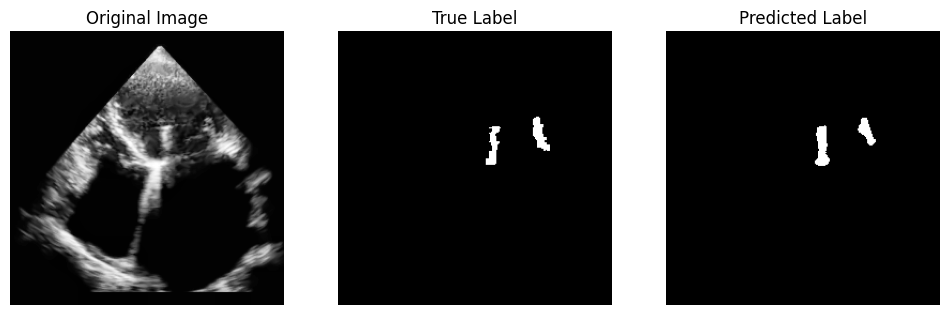

In [20]:
import matplotlib.pyplot as plt

# Select the first image from X_test
sample_index = 0
sample_image = X_test[sample_index]

true_label = y_test[sample_index]
predicted_label = y_pred_binary[sample_index]

# Plot the original image
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Plot the true label
plt.subplot(132)
plt.imshow(true_label.squeeze(), cmap='gray')
plt.title("True Label")
plt.axis('off')

# Plot the predicted label
plt.subplot(133)
plt.imshow(predicted_label.squeeze(), cmap='gray')
plt.title("Predicted Label")
plt.axis('off')

plt.show()


### Real Test predictions

In [45]:
real_test_data = load_zipped_pickle("/content/drive/MyDrive/data/test_processed.pkl")


In [46]:
real_test_data_not_processed = load_zipped_pickle("/content/drive/MyDrive/data/test.pkl")

In [47]:
import numpy as np
import cv2

predictions = []

for processed_entry, original_entry in zip(real_test_data, real_test_data_not_processed):
    video_frames = processed_entry['video']
    num_frames = video_frames.shape[2]
    prediction_frames = []

    original_height, original_width = original_entry['video'].shape[:2]

    for i in range(num_frames):
        frame = video_frames[:, :, i]
        frame_reshaped = np.expand_dims(frame, axis=0)
        frame_reshaped = np.expand_dims(frame_reshaped, axis=-1)

        # Predict mask
        pred_mask = unet.predict(frame_reshaped)
        pred_binary_mask = (pred_mask > 0.5).astype(np.uint8)

        pred_resized = cv2.resize(pred_binary_mask[0, :, :, 0], (original_width, original_height), interpolation=cv2.INTER_NEAREST)
        pred_resized = pred_resized.astype(np.bool)
        prediction_frames.append(pred_resized)

    prediction = np.stack(prediction_frames, axis=-1)

    # Data Structure
    predictions.append({
        'name': processed_entry['name'],
        'prediction': prediction
    })

# Save predictions in the correct format
save_zipped_pickle(predictions, 'predictions_unet.pkl')


1/1 [==============================] - 0s 30ms/step


<ipython-input-47-caeb2f9d09c3>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_resized = pred_resized.astype(np.bool)


1/1 [==============================] - 0s 20ms/step


In [27]:
#sample_data = load_zipped_pickle("/content/drive/MyDrive/data/sample.pkl")
